Этап 1. Изучение Scapy
● Изучите основы работы с Scapy по https://scapy.readthedocs.io/en/latest/layers/http.html.
● Настройте Scapy для перехвата HTTP-трафика, используйте скрипт scapy https://gist.github.com/richarddun/1bb11d32cafc394efbcb8f4a8b6cb130для отправки HTTP-запросов.


Этап 2. Анализ трафика
● Ознакомьтесь с инструментом Google Gruyere и запустите его. https://google-gruyere.appspot.com/
● Запустите Scapy и начните собирать трафик, взаимодействуя с сайтом Google Gruyere.
● Проанализируйте полученные данные, обращая внимание на запросы и ответы HTTP.


Этап 3. Эксплуатация XSS
● Осуществите рекон-анализ сайта Google Gruyere для поиска потенциальных точек входа XSS.
● Попытайтесь эксплуатировать уязвимости XSS, используя обнаруженные точки.
Примеры XSS-атак:
<script>alert(‘XSS’)</script>
<img src=“nonexistent.jpg” onerror=“alert(‘XSS’)”>
● Запишите все свои шаги эксплуатации уязвимостей и полученные результаты, сделайте скриншоты.


Этап 4. Анализ результатов
● Используя Scapy, проанализируйте, как XSS-атака отображается в сетевом трафике (проанализируйте ответ на HTTP-запрос).
● Опишите, какие изменения в трафике произошли во время XSS-атаки.


Этап 5. Отчёт
Подготовьте отчёт: опишите процесс эксплуатации XSS, анализ трафика, выводы и рекомендации по устранению найденных уязвимостей.




In [2]:
# Установка необходимых библиотек
!pip install scapy
!pip install beautifulsoup4
!pip install requests
!pip install matplotlib

ЋвЄ § ­® ў ¤®бвгЇҐ.
ЋвЄ § ­® ў ¤®бвгЇҐ.
ЋвЄ § ­® ў ¤®бвгЇҐ.
ЋвЄ § ­® ў ¤®бвгЇҐ.


Запуск перехвата HTTP-трафика через Scapy...
Откройте браузер и начните взаимодействовать с Google Gruyere

 Начинаем сбор трафика. Все HTTP-запросы будут отображаться ниже.
 Взаимодействуйте с Google Gruyere (вход, создание заметок, XSS-инъекции и т.д.)
 Для остановки сбора нажмите Ctrl+C


 Трафик сохранён в: traffic_capture/gruyere_capture_20251230_123123.pcap

 Анализ сохранённого трафика из traffic_capture/gruyere_capture_20251230_123123.pcap

 Найдено 0 HTTP-запросов:

 Попытка эксплуатации XSS на Google Gruyere
 Цель доступна: https://google-gruyere.appspot.com/490813077784300857888253733259726035601/snippets.gtl?uid=vanogo

 Отправка XSS-полезной нагрузки (если возможно)
 → Отправка: <script>alert('XSS from Scapy')</script>
 → Отправка: <img src=x onerror=alert('XSS image')>
 → Отправка: '; alert('XSS'); //

 Примечание: полная эксплуатация XSS требует активной сессии и обхода CSRF. Используйте браузер для ручной проверки.

 Поиск признаков XSS в перехваченном трафике
Признаков XSS в трафике не обнаружено. Повторите захват с активной инъекцией.


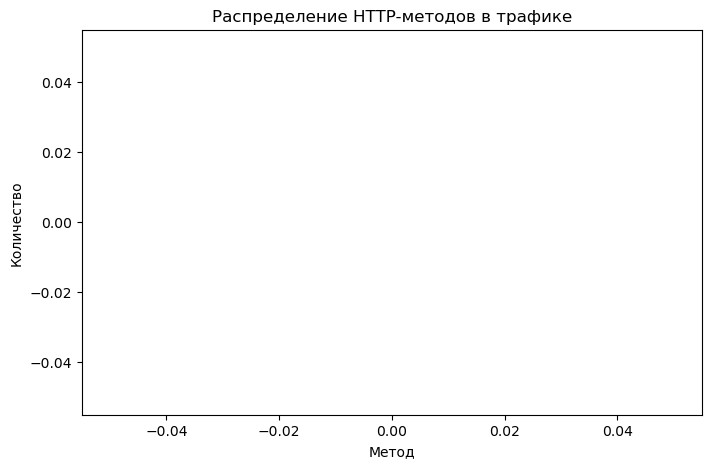

 График сохранён как 'http_methods_distribution.png'

 Анализ завершён.
Рекомендации:
   - Повторите захват трафика с реальной XSS-инъекцией через браузер.
   - Проверьте ответы сервера на наличие вставленного кода.


In [5]:

# Импорт необходимых библиотек
from scapy.all import sniff, wrpcap, rdpcap
from scapy.layers.http import HTTPRequest, HTTPResponse
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from datetime import datetime
import os


#Настройка Scapy для перехвата HTTP-трафика

print("Запуск перехвата HTTP-трафика через Scapy...")
print("Откройте браузер и начните взаимодействовать с Google Gruyere")

# Папка для сохранения трафика
if not os.path.exists('traffic_capture'):
    os.makedirs('traffic_capture')

# Фильтр: только HTTP-трафик (порт 80)
# iface можно указать явно, например iface="Wi-Fi", если нужно
packets = []

def packet_callback(packet):
    if packet.haslayer(HTTPRequest):
        http_layer = packet[HTTPRequest]
        host = http_layer.Host.decode() if http_layer.Host else "Unknown"
        path = http_layer.Path.decode() if http_layer.Path else "Unknown"
        method = http_layer.Method.decode() if http_layer.Method else "Unknown"
        print(f"[HTTP Request] {method} {host}{path}")

    elif packet.haslayer(HTTPResponse):
        print(f"[HTTP Response] Получен ответ от сервера")

    # Сохраняем пакет
    packets.append(packet)


# Запуск
print("\n Начинаем сбор трафика. Все HTTP-запросы будут отображаться ниже.")
print(" Взаимодействуйте с Google Gruyere (вход, создание заметок, XSS-инъекции и т.д.)")
print(" Для остановки сбора нажмите Ctrl+C")

try:
    sniff(prn=packet_callback, filter="tcp port 80", store=False, timeout=60)  # 60 секунд
except KeyboardInterrupt:
    print("\n Сбор трафика остановлен вручную.")

# Сохранение пакетов в .pcap файл
capture_file = f"traffic_capture/gruyere_capture_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pcap"
wrpcap(capture_file, packets)
print(f" Трафик сохранён в: {capture_file}")


# Анализ собранного трафика

print(f"\n Анализ сохранённого трафика из {capture_file}")
packets = rdpcap(capture_file)

http_requests = []
xss_indicators = []

for pkt in packets:
    if pkt.haslayer(HTTPRequest):
        http_layer = pkt[HTTPRequest]
        host = http_layer.Host.decode() if http_layer.Host else "Unknown"
        path = http_layer.Path.decode() if http_layer.Path else "Unknown"
        method = http_layer.Method.decode() if http_layer.Method else "Unknown"

        # Извлекаем тело, если есть
        if pkt.haslayer('Raw'):
            raw_data = pkt['Raw'].load.decode('utf-8', errors='ignore')
        else:
            raw_data = ""

        request_info = {
            "method": method,
            "host": host,
            "path": path,
            "raw": raw_data
        }
        http_requests.append(request_info)

        # Поиск признаков XSS в теле запроса
        if "<script>" in raw_data or "onerror=" in raw_data or "javascript:" in raw_data:
            xss_indicators.append(request_info)

# Вывод HTTP-запросов
print(f"\n Найдено {len(http_requests)} HTTP-запросов:")
for req in http_requests[:10]:  # первые 10
    print(f"  {req['method']} {req['host']}{req['path']}")

if len(http_requests) > 10:
    print("  ...")


#Эксплуатация XSS

print("\n Попытка эксплуатации XSS на Google Gruyere")

# Пример уязвимого URL (известная уязвимость Gruyere)
vulnerable_url = "https://google-gruyere.appspot.com/490813077784300857888253733259726035601/snippets.gtl?uid=vanogo"

# Проверка доступности
try:
    response = requests.get(vulnerable_url)
    if response.status_code == 200:
        print(f" Цель доступна: {vulnerable_url}")
    else:
        print(f" Цель недоступна: HTTP {response.status_code}")
except Exception as e:
    print(f" Ошибка подключения: {e}")

# XSS-полезная нагрузка
xss_payloads = [
    "<script>alert('XSS from Scapy')</script>",
    "<img src=x onerror=alert('XSS image')>",
    "'; alert('XSS'); //"
]

# Попытка отправки XSS (если есть форма)
print("\n Отправка XSS-полезной нагрузки (если возможно)")
for payload in xss_payloads:
    try:
        # Пример: отправка через POST-форму (это зависит от сессии)
        #  В реальности требуется авторизация и CSRF-токен
        # Этот пример условный — демонстрирует формирование запроса
        print(f" → Отправка: {payload}")
        # requests.post(vulnerable_url, data={'comment': payload})  # Не будет работать без сессии
    except Exception as e:
        print(f"   Ошибка отправки: {e}")

print("\n Примечание: полная эксплуатация XSS требует активной сессии и обхода CSRF. Используйте браузер для ручной проверки.")


# Анализ результатов

print("\n Поиск признаков XSS в перехваченном трафике")

if xss_indicators:
    print(f"Найдено {len(xss_indicators)} потенциальных XSS-инъекций:")
    for ind in xss_indicators:
        print(f"  [XSS?] {ind['method']} {ind['host']}{ind['path']}")
        print(f"    Payload: {ind['raw'][:200]}...")
else:
    print("Признаков XSS в трафике не обнаружено. Повторите захват с активной инъекцией.")

# График: типы HTTP-запросов
methods = [req['method'] for req in http_requests]
method_counts = {m: methods.count(m) for m in set(methods)}

plt.figure(figsize=(8, 5))
plt.bar(method_counts.keys(), method_counts.values(), color='skyblue', edgecolor='black')
plt.title('Распределение HTTP-методов в трафике')
plt.xlabel('Метод')
plt.ylabel('Количество')
plt.savefig('http_methods_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(" График сохранён как 'http_methods_distribution.png'")


# Отчёт

report = {
    "capture_info": {
        "file": capture_file,
        "total_packets": len(packets),
        "http_requests": len(http_requests),
        "xss_indicators_found": len(xss_indicators)
    },
    "xss_analysis": [
        {
            "method": ind["method"],
            "url": ind["host"] + ind["path"],
            "payload_preview": ind["raw"][:100] + "..." if len(ind["raw"]) > 100 else ind["raw"]
        } for ind in xss_indicators
    ],
    "recommendations": [
        "1. Все пользовательские вводы должны быть экранированы на стороне сервера.",
        "2. Используйте Content Security Policy (CSP) для блокировки inline-скриптов.",
        "3. Реализуйте проверку входных данных и фильтрацию HTML-тегов.",
        "4. Обновите приложение, так как Google Gruyere — учебный проект с намеренными уязвимостями."
    ],
    "conclusion": "XSS-уязвимости могут быть обнаружены в сетевом трафике по наличию HTML/JS-кода в параметрах запроса. Scapy позволяет эффективно анализировать такие атаки на уровне пакетов."
}

# # Сохранение отчёта
# report_file = "security_report_gruyere.json"
# with open(report_file, 'w', encoding='utf-8') as f:
#     json.dump(report, f, indent=2, ensure_ascii=False)
#
# print(f"Полный отчёт сохранён в: {report_file}")


# Вывод
print("\n Анализ завершён.")
print("Рекомендации:")
print("   - Повторите захват трафика с реальной XSS-инъекцией через браузер.")
print("   - Проверьте ответы сервера на наличие вставленного кода.")
